<a href="https://colab.research.google.com/github/Ruush07/Tumor-detection-project/blob/main/Brain_Tumor_Detection_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for **Brain** Tumor Detection Using Pytorch

In [ ]:
!pip install split-folders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Step 2: Specify the path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Brain Tumor Data Set.zip'
extract_dir = '/content/drive/MyDrive/Brain Tumor Data Set'

# Ensure the extract directory exists
os.makedirs(extract_dir, exist_ok=True)

# Step 3: Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
os.listdir("/content/drive/MyDrive/Brain Tumor Data Set/Brain Tumor Data Set")

['Brain Tumor', 'Healthy']

In [ ]:
data_dir = "/content/drive/MyDrive/Brain Tumor Data Set/Brain Tumor Data Set"
data_dir = pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output='brain', seed=41, ratio=(0.8, 0.2))

Copying files: 4600 files [02:45, 27.82 files/s] 


In [ ]:
data_dir = "/content/brain"
data_dir = pathlib.Path(data_dir)

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [ ]:
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('train'), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('val'), transform=transform)
val_set.transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
print(train_set)

Dataset ImageFolder
    Number of datapoints: 3679
    Root location: /content/brain/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


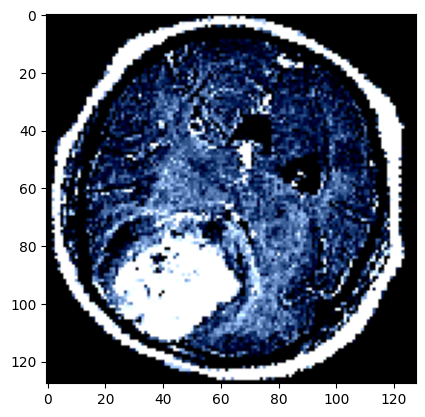

In [ ]:
img, label = train_set[1000]
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
next(iter(val_loader))[0].shape

torch.Size([64, 3, 128, 128])

In [ ]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    #Conv 1
    self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #128-5+1=124

    #Max Pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) #124/2 = 64

    #Conv 2
    self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #60

    #Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) #30

    #Conv 3
    self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) #26

    #Max Pool 3
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) #13

    #Conv 4
    self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0) #9

    #Max Pool 4
    self.maxpool4 = nn.MaxPool2d(kernel_size=2) #4

    #Activation Function
    self.leakyRelu = nn.LeakyReLU()

    #Fully connected Layer 1
    self.fc1 = nn.Linear(128*4*4, 1024)

    #Fully connected Layer 2
    self.fc2 = nn.Linear(1024, 2)

  def forward(self, x):
    #Layer 1
    out = self.leakyRelu(self.cnv1(x))
    out = self.maxpool1(out)

    #Layer 2
    out = self.leakyRelu(self.cnv2(out))
    out = self.maxpool2(out)

    #Layer 3
    out = self.leakyRelu(self.cnv3(out))
    out = self.maxpool3(out)

    #Layer 4
    out = self.leakyRelu(self.cnv4(out))
    out = self.maxpool4(out)

    #flatten
    out = out.view(out.size(0), -1)

    # Linear Function
    out = self.leakyRelu(self.fc1(out))
    out = self.fc2(out)

    return out



In [ ]:
# Training CNN
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    outputs = model(images)
    loss = error(outputs, labels)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    correct+=(predicted==labels).sum()


  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Acciracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))

Loss in Iteration: 0 : 0.6927366852760315
Loss in Iteration: 1 : 0.8313121199607849
Loss in Iteration: 2 : 0.6774230599403381
Loss in Iteration: 3 : 0.7577914595603943
Loss in Iteration: 4 : 0.6948931217193604
Loss in Iteration: 5 : 0.6902090907096863
Loss in Iteration: 6 : 0.6956904530525208
Loss in Iteration: 7 : 0.6877793669700623
Loss in Iteration: 8 : 0.687325656414032
Loss in Iteration: 9 : 0.6973744034767151
Loss in Iteration: 10 : 0.6915191411972046
Loss in Iteration: 11 : 0.686689019203186
Loss in Iteration: 12 : 0.6965746283531189
Loss in Iteration: 13 : 0.6769287586212158
Loss in Iteration: 14 : 0.6737024784088135
Loss in Iteration: 15 : 0.6754982471466064
Loss in Iteration: 16 : 0.7028927206993103
Loss in Iteration: 17 : 0.6235804557800293
Loss in Iteration: 18 : 0.678848385810852
Loss in Iteration: 19 : 0.7503587007522583
Loss in Iteration: 20 : 0.6824415922164917
Loss in Iteration: 21 : 0.6874995827674866
Loss in Iteration: 22 : 0.6944111585617065
Loss in Iteration: 23 : 

In [ ]:
train_loss_list

[0.6747854146464117,
 0.5676144926712431,
 0.444984317853533,
 0.3937813665332465,
 0.3264911544734034,
 0.26912943325166044,
 0.23238347457914516,
 0.1877376422414492,
 0.15893379977807917,
 0.14081322318264122]

In [ ]:
val_loss_list

[0.6070284644762675,
 0.46723085443178813,
 0.3609366854031881,
 0.3641016085942586,
 0.2640925168991089,
 0.23033503592014312,
 0.1782901038726171,
 0.16362027277549107,
 0.1394489491979281,
 0.12132417112588882]

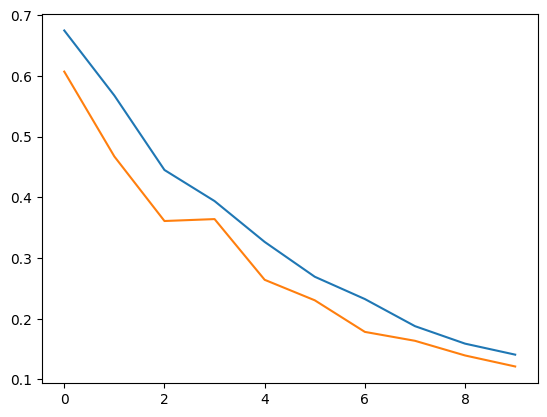

In [ ]:
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)

In [ ]:
accuracy_list

[tensor(73.0727),
 tensor(79.1531),
 tensor(84.2562),
 tensor(83.9305),
 tensor(90.8795),
 tensor(90.5537),
 tensor(93.8111),
 tensor(93.8111),
 tensor(95.5483),
 tensor(96.3084)]

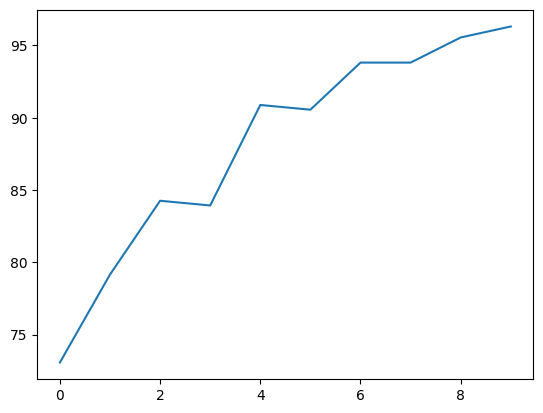

In [ ]:
plt.plot(range(num_epochs), accuracy_list)

Text(0.5, 1.0, '0')

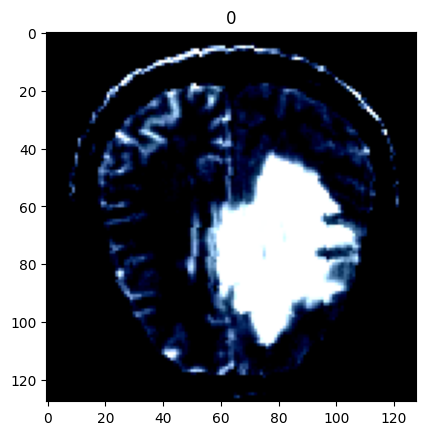

In [ ]:
img, label = val_set[500]
plt.imshow(img.permute(1,2,0))
plt.title(label)

In [ ]:
image = img.unsqueeze(0)

with torch.no_grad():
  output = model(image)

_, pred = torch.max(output, 1)
print("Predicted Output:", pred.item())

Predicted Output: 0
